LSTM que atende melhor esse problema, é a Multivariate LSTM - que ainda pode ser, Single-step Model (quando vc busca por apenas um valor no futuro) ou Multistep model (quando busca por multiplos valores no futuro)

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tensorflow import keras
from keras import backend as K
import IPython
!pip install -q -U keras-tuner
import kerastuner as kt
from kerastuner import HyperModel
from sklearn import metrics

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = True

     |████████████████████████████████| 135 kB 4.0 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  # This is added back by InteractiveShellApp.init_path()


Neste caso, apenas utilizei os valores diarios do preco do dolar, de abertura, fechametno, minima e maxima.

In [ ]:
df=pd.read_csv(r'/content/sample_data/Untitled.csv', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0]}, index_col=['datetime'])
df.head()

,Abertura,Maxima,Minima,Fechamento
datetime,,,,
2022-07-06,5444.5,5479.0,5431.5,5478.5
2022-07-05,5394.0,5443.5,5388.5,5428.0
2022-07-04,5339.0,5376.0,5329.5,5373.0
2022-07-01,5329.0,5381.0,5319.5,5372.5
2022-06-30,5268.0,5314.0,5231.0,5296.0


Funcoes

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, std, mean, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i]*std +mean, marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, (plot_data[i]*std + mean).flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  plt.ylabel('Dolar')
  return plt

  # The function that calculate RMSE
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))


def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('RMSE')

  plt.legend()

  plt.show()


def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)




def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')


se utilizar um df com amis features, basta colocar o nome aqui:


In [ ]:
features_considered = ['Abertura','Maxima', 'Minima', 'Fechamento']
features = df[features_considered]
features.head

<bound method NDFrame.head of             Abertura  Maxima  Minima  Fechamento
datetime                                        
2022-07-06    5444.5  5479.0  5431.5      5478.5
2022-07-05    5394.0  5443.5  5388.5      5428.0
2022-07-04    5339.0  5376.0  5329.5      5373.0
2022-07-01    5329.0  5381.0  5319.5      5372.5
2022-06-30    5268.0  5314.0  5231.0      5296.0
...              ...     ...     ...         ...
2018-06-28    3850.0  3878.5  3835.0      3866.0
2018-06-27    3794.0  3879.0  3791.5      3861.0
2018-06-26    3786.0  3804.5  3763.0      3799.0
2018-06-25    3779.5  3788.5  3763.0      3777.0
2018-06-22    3758.5  3791.0  3739.0      3786.0

[1000 rows x 4 columns]>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c5c2f9790>,
      dtype=object)

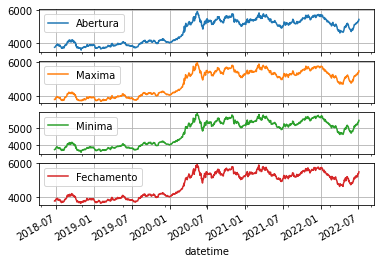

In [ ]:
features.plot(subplots=True)

# LSTM-RNN é sensivel a normalizacao dos dados.


In [ ]:

TRAIN_SPLIT=int(features.shape[0]*.8)
#print(TRAIN_SPLIT)
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std
dataset

array([[ 0.77028843,  0.74916798,  0.82505736,  0.82280822],
       [ 0.68745191,  0.69185041,  0.75329039,  0.73996802],
       [ 0.59723391,  0.58286628,  0.65481942,  0.64974603],
       ...,
       [-1.95019425, -1.95444564, -1.95966823, -1.93224353],
       [-1.96085638, -1.98027891, -1.95966823, -1.96833233],
       [-1.99530325, -1.97624246, -1.99972422, -1.95356873]])

# Single Step

veja que coloquei a Target como dataset[:, 3], a ultima coluna. que é o FECHAMENTO

In [ ]:
past_history = 120
future_target = 0
STEP = 1

# dataset, target, start_index, end_index, history_size, target_size, step, single_step=False


x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 3], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 3],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [ ]:
print ('Single window of past history : {}'.format(x_train_single.shape))
print(y_train_single.shape)

Single window of past history : (680, 120, 4)
(680,)


In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EPOCHS = 20

#treino
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

#validacao
val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
## arquitetura do modelo
single_step_model = tf.keras.models.Sequential()
##camada LSTM
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
##camada Dropout -- limpar aqueles que nao esta ajudando
single_step_model.add(tf.keras.layers.Dropout(.09))
#camada dense, fully connected layer, e traz apenas um output.
single_step_model.add(tf.keras.layers.Dense(1))

##testar com outros otimizadores!
single_step_model.compile(optimizer='SGD', loss=root_mean_squared_error)

In [ ]:
single_step_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4736      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [ ]:
##treinamento do Modelo - FIT.
#aqui vai acompanhando o valor do loss, e deve ir reduzindo.


EPOCHS = 10

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=TRAIN_SPLIT,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
800/800 [==============================] - 47s 54ms/step - loss: 0.1647 - val_loss: 0.1076
Epoch 2/10
800/800 [==============================] - 41s 51ms/step - loss: 0.1170 - val_loss: 0.0918
Epoch 3/10
800/800 [==============================] - 57s 72ms/step - loss: 0.1072 - val_loss: 0.0886
Epoch 4/10
800/800 [==============================] - 44s 55ms/step - loss: 0.1004 - val_loss: 0.0756
Epoch 5/10
800/800 [==============================] - 42s 52ms/step - loss: 0.0952 - val_loss: 0.0696
Epoch 6/10
800/800 [==============================] - 45s 56ms/step - loss: 0.0921 - val_loss: 0.0681
Epoch 7/10
800/800 [==============================] - 47s 59ms/step - loss: 0.0887 - val_loss: 0.0628
Epoch 8/10
800/800 [==============================] - 39s 49ms/step - loss: 0.0861 - val_loss: 0.0635
Epoch 9/10
800/800 [==============================] - 35s 44ms/step - loss: 0.0847 - val_loss: 0.0578
Epoch 10/10
800/800 [==============================] - 34s 43ms/step - loss: 0.082

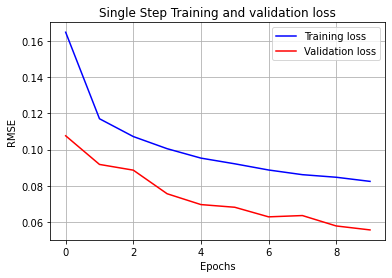

In [ ]:
##chart do loss

plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

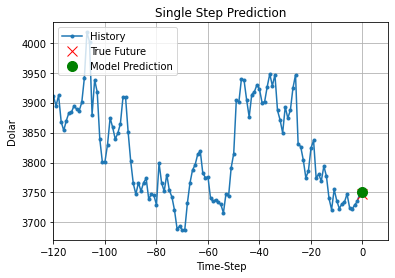

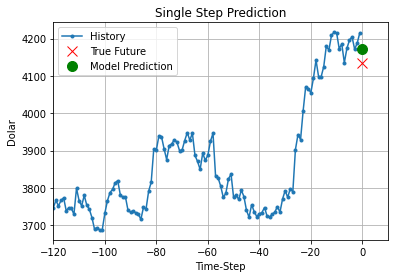

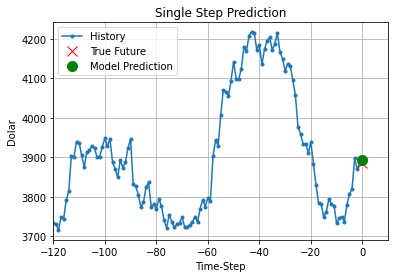

In [ ]:
#resultado da predicao

for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]],data_std[1],data_mean[1], 0,
                   'Single Step Prediction')
  plot.show()

In [ ]:
#x_val_single, y_val_single

Predicted_results = single_step_model.predict(x_val_single)
timeseries_evaluation_metrics_func(y_val_single,Predicted_results)


Evaluation metric results:-
MSE is : 0.0031597675659743875
MAE is : 0.04327737047819013
RMSE is : 0.05621180984432353
MAPE is : 16.877996160589316
R2 is : 0.9480403918358701



#multi-step

In [ ]:
future_target = 5 ## 5 pontos no futuro --neste caso, 5 dias.

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [ ]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target Dolar $ to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 4)

 Target Dolar $ to predict : (5,)


In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
def multi_step_plot(history, true_future, prediction,Title):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]*data_std[1]+data_mean[1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future*data_std[1]+data_mean[1]), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction*data_std[1] + data_mean[1]), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.xlabel('Time-Step')
  plt.ylabel('Temperature(°C)')
  plt.title(Title)
  plt.show()

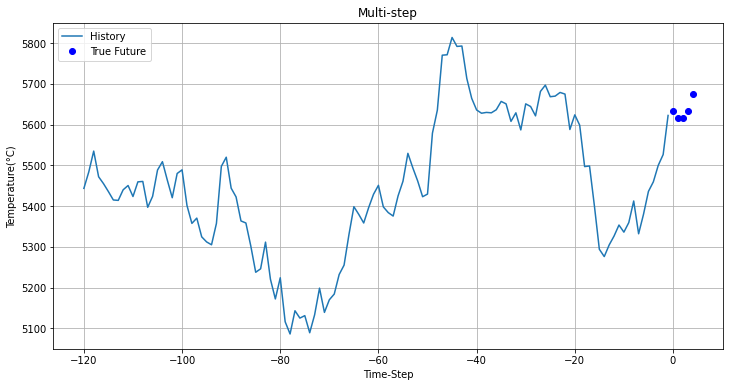

In [ ]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]),'Multi-step')

In [ ]:
## treinando o modelo para multstep

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(5))

multi_step_model.compile(optimizer='SGD', loss=root_mean_squared_error)

In [ ]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(32, 5)


In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=TRAIN_SPLIT,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
800/800 [==============================] - 76s 92ms/step - loss: 0.3582 - val_loss: 0.1994
Epoch 2/10
800/800 [==============================] - 68s 85ms/step - loss: 0.1850 - val_loss: 0.1530
Epoch 3/10
800/800 [==============================] - 74s 92ms/step - loss: 0.1703 - val_loss: 0.1457
Epoch 4/10
800/800 [==============================] - 67s 84ms/step - loss: 0.1667 - val_loss: 0.1391
Epoch 5/10
800/800 [==============================] - 68s 85ms/step - loss: 0.1626 - val_loss: 0.1278
Epoch 6/10
800/800 [==============================] - 67s 84ms/step - loss: 0.1551 - val_loss: 0.1227
Epoch 7/10
800/800 [==============================] - 69s 86ms/step - loss: 0.1525 - val_loss: 0.1224
Epoch 8/10
800/800 [==============================] - 71s 89ms/step - loss: 0.1495 - val_loss: 0.1247
Epoch 9/10
800/800 [==============================] - 68s 85ms/step - loss: 0.1474 - val_loss: 0.1234
Epoch 10/10
800/800 [==============================] - 65s 81ms/step - loss: 0.146

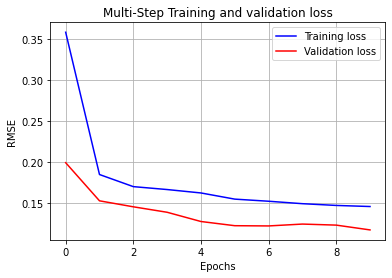

In [ ]:
##plot do resultado
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

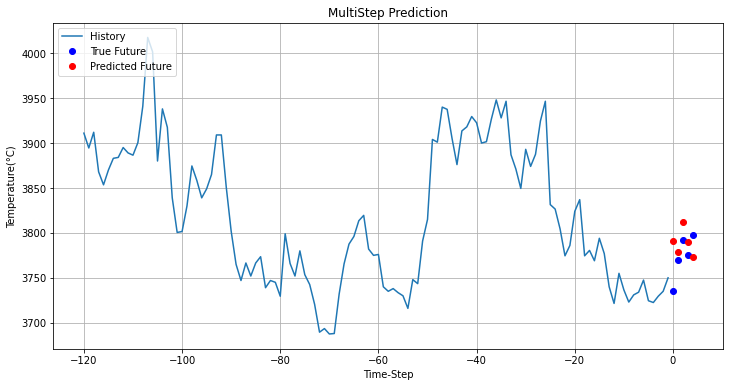

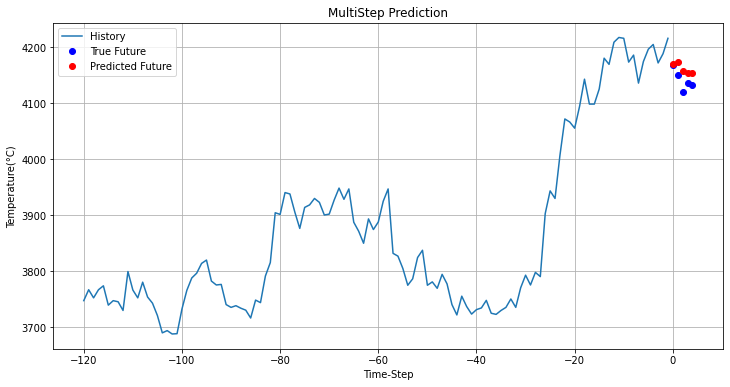

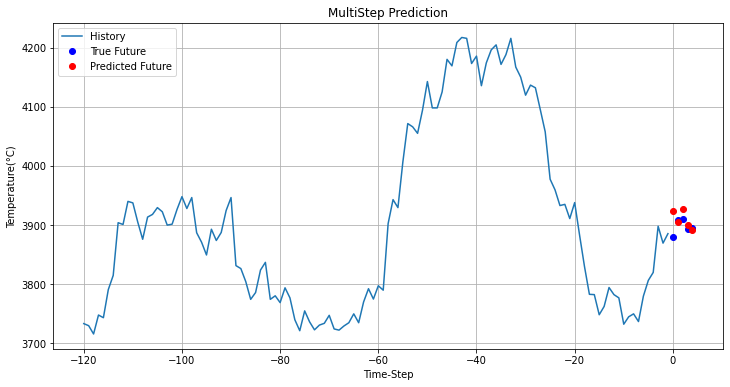

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0],'MultiStep Prediction')

In [ ]:
val_data_multi.take(3)

<TakeDataset element_spec=(TensorSpec(shape=(None, 120, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
x_val_multi

array([[[-1.79600349, -1.7824929 , -1.76773329, -1.75508034],
        [-1.78616153, -1.80913347, -1.79276828, -1.80675293],
        [-1.78288087, -1.78087832, -1.79109928, -1.79116913],
        ...,
        [-2.07813977, -2.07553911, -2.08067069, -2.06593613],
        [-2.09700354, -2.06665892, -2.10403668, -2.05363313],
        [-2.01744767, -2.04244023, -2.11822318, -2.10940673]],

       [[-1.78616153, -1.80913347, -1.79276828, -1.80675293],
        [-1.78288087, -1.78087832, -1.79109928, -1.79116913],
        [-1.85833593, -1.85191983, -1.83783127, -1.82889833],
        ...,
        [-2.09700354, -2.06665892, -2.10403668, -2.05363313],
        [-2.01744767, -2.04244023, -2.11822318, -2.10940673],
        [-2.04533323, -2.06665892, -2.07316019, -2.04543113]],

       [[-1.78288087, -1.78087832, -1.79109928, -1.79116913],
        [-1.85833593, -1.85191983, -1.83783127, -1.82889833],
        [-1.85997625, -1.87533123, -1.86453526, -1.88057093],
        ...,
        [-2.01744767, -2.04

In [ ]:
#val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
Predicted_results = multi_step_model.predict(x_val_multi)
timeseries_evaluation_metrics_func(y_val_multi,Predicted_results)





Evaluation metric results:-
MSE is : 0.013930716556204342
MAE is : 0.09086860229886012
RMSE is : 0.11802845655266506
MAPE is : 5.427831038939041
R2 is : 0.7759930183717897

